# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf



# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

In [2]:
# Load the data
data = pd.read_csv('DAYTON_hourly.csv', engine='python', skipfooter=3)
data

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0
...,...,...
121267,2018-01-01 17:00:00,2441.0
121268,2018-01-01 18:00:00,2617.0
121269,2018-01-01 19:00:00,2714.0
121270,2018-01-01 20:00:00,2732.0


In [3]:
data.columns=['Datetime','Consommation']
data

,Datetime,Consommation
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0
...,...,...
121267,2018-01-01 17:00:00,2441.0
121268,2018-01-01 18:00:00,2617.0
121269,2018-01-01 19:00:00,2714.0
121270,2018-01-01 20:00:00,2732.0


In [4]:
data.dropna(inplace=True)
data.head()
data.loc[:5000] 

,Datetime,Consommation
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0
...,...,...
4996,2005-09-06 07:00:00,1960.0
4997,2005-09-06 08:00:00,2075.0
4998,2005-09-06 09:00:00,2166.0
4999,2005-09-06 10:00:00,2259.0


In [5]:
data.isnull().sum()

Datetime        0
Consommation    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121272 entries, 0 to 121271
Data columns (total 2 columns):
Datetime        121272 non-null object
Consommation    121272 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.8+ MB


In [7]:
data.describe()

,Consommation
count,121272.000000
mean,2037.836986
std,393.397660
min,982.000000
25%,1749.000000
50%,2009.000000
75%,2279.000000
max,3746.000000


In [5]:

res = dict()
# Boucle sur la Dataframe pour calculer la moyenne de consommation
# d'une journée, on utilise un dictionnaire qui à la fin contient
# une liste de taille 2 [somme des consommations du jours,
# nombre d'heures prélever]
for index in range(len(data)):
    # Identification du mois
    annee_mois = data['Datetime'][index][:7]
    # Si la date est déja rencontré
    try:
        # On rajoute la,consommation de l'heure
        res[annee_mois][1] += data['Consommation'][index]
        # Puis on incrémente le compteur
        res[annee_mois][0] += 1
    except KeyError:
        # On a rencontré la date la première fois
        # On initialise nos valeur
        res[annee_mois] = [1, data['Consommation'][index]]
#----------
       
# Puis je crée mon propre dataframe avec les données que j'ai
dict_data = {'Date': [], 'Consommation': []}
# Que je remplit avec les dates et les moyennes de consommations
for date_to_put, [nb_time, somme_conso] in res.items():
    dict_data['Date'].append(date_to_put)
    dict_data['Consommation'].append(somme_conso/ nb_time)
# Dataframe final
new_data = pd.DataFrame(data = dict_data)
new_data['Date'] = pd.to_datetime(new_data['Date'], format='%Y-%m-%d')
new_data.set_index(['Date'], inplace=True)
new_data = new_data.sort_index()
new_data.to_csv(r"C:/Users/OUMAIMA/Desktop/deep-learning-ts-master/ARIMA-master/new_data.csv")

new_data.head()


,Consommation
Date,
2004-10-01,1866.481132
2004-11-01,1930.211111
2004-12-01,2163.391129
2005-01-01,2219.696237
2005-02-01,2155.599702


In [9]:
new_data.describe()

,Consommation
count,167.000000
mean,2038.393650
std,193.275121
min,1695.412500
25%,1871.003616
50%,2037.115278
75%,2161.940726
max,2590.948925


In [10]:
for key in res.items() :
    print (key)

('2004-12', [744, 1609563.0])
('2005-01', [744, 1651454.0])
('2004-11', [720, 1389752.0])
('2004-10', [742, 1384929.0])
('2005-12', [744, 1689285.0])
('2006-01', [744, 1556215.0])
('2005-11', [720, 1447304.0])
('2005-10', [743, 1439729.0])
('2005-09', [720, 1546943.0])
('2005-08', [744, 1835677.0])
('2005-07', [744, 1780733.0])
('2005-06', [720, 1661649.0])
('2005-05', [744, 1364190.0])
('2005-04', [719, 1342504.0])
('2005-03', [744, 1549617.0])
('2005-02', [672, 1448563.0])
('2006-12', [744, 1568846.0])
('2007-01', [744, 1663133.0])
('2006-11', [720, 1466723.0])
('2006-10', [743, 1456739.0])
('2006-09', [720, 1404713.0])
('2006-08', [744, 1823546.0])
('2006-07', [744, 1776279.0])
('2006-06', [720, 1548908.0])
('2006-05', [744, 1420201.0])
('2006-04', [719, 1318377.0])
('2006-03', [744, 1545849.0])
('2006-02', [672, 1475218.0])
('2007-12', [744, 1622906.0])
('2008-01', [744, 1726859.0])
('2007-11', [719, 1448459.0])
('2007-10', [744, 1500002.0])
('2007-09', [720, 1557624.0])
('2007-08'

In [11]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2004-10-01 to 2018-08-01
Data columns (total 1 columns):
Consommation    167 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


<Figure size 1440x360 with 0 Axes>

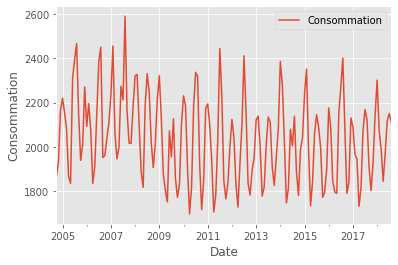

In [6]:
# Plot the new data
plt.figure(figsize=(20, 5))
new_data.plot()
plt.ylabel('Consommation')
plt.xlabel('Date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ renvoie des valeurs pour AIC (Akaike Information Criterion) et BIC (Bayes Information Criterion) qui peuvent être minimisées pour sélectionner le modèle le mieux adapté. Nous utilisons la valeur AIC, qui estime les informations perdues lorsqu'un modèle donné est utilisé pour représenter le processus qui génère les données. Ce faisant, il traite du compromis entre la qualité de l'ajustement du modèle et la complexité du modèle lui-même.

In [8]:
# Définir les paramètres d et q pour prendre une valeur entre 0 et 1 
q = d = range(0, 2)
# Définir le paramètre p pour prendre une valeur entre 0 et 3
p = range(0, 4)

# Générer toutes les combinaisons différentes de triplets p, q et q
pdq = list(itertools.product(p, d, q))

#Générer toutes les combinaisons différentes de triplets saisonniers p, q et q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Exemples de combinaisons de paramètres pour ARIMA saisonnier...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Exemples de combinaisons de paramètres pour ARIMA saisonnier...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Nous sélectionnons un sous-ensemble de la série de données comme données d'apprentissage, disons les 11 premières années. Notre objectif est de prédire la dernière année de la série sur la base de cette entrée

In [9]:
train_data = new_data.loc['2004-10-01':'2017-06-01']
test_data=new_data.loc['2017-07-01':'2018-08-01']


In [30]:


warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
            




In [11]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 1220.802352228487 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [12]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

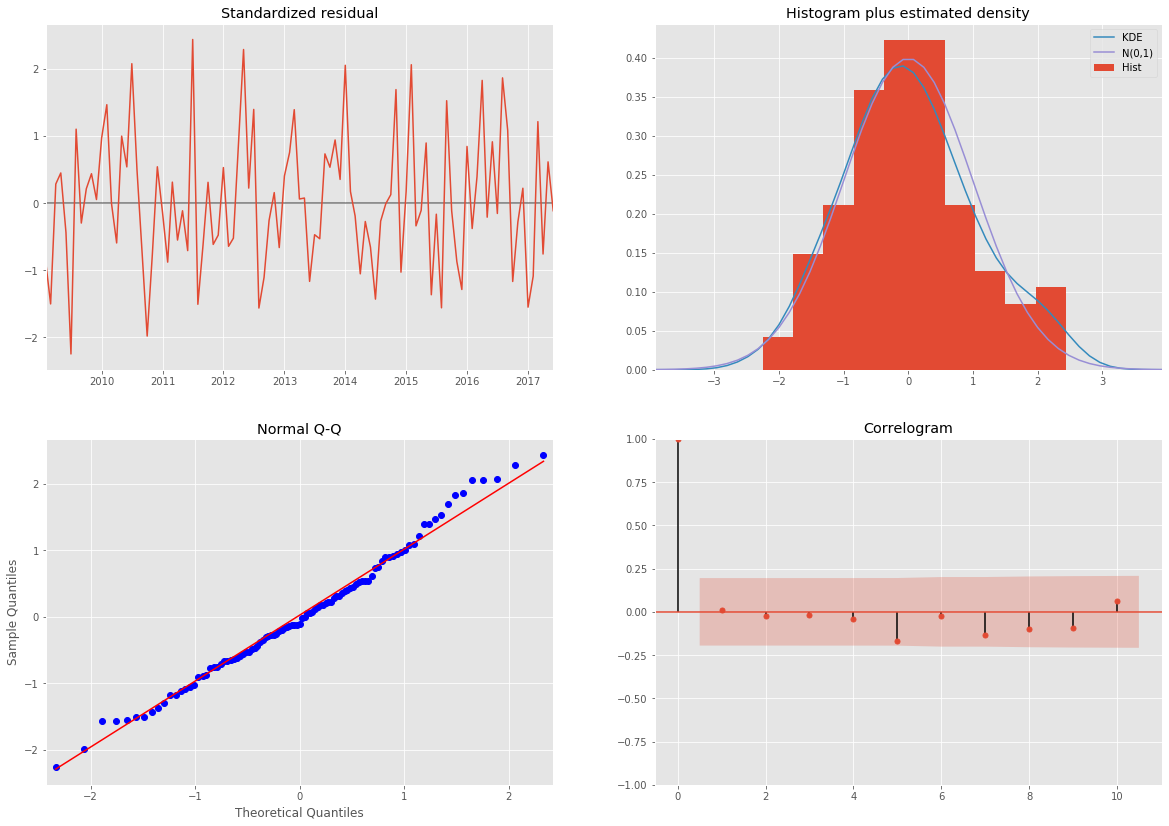

In [13]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [14]:
import time
start = time.time()

pred0 = results.get_prediction(start='2016-07-01', dynamic=False)
pred0_ci = pred0.conf_int()

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')

Temps d'exécution : 0.013ms


2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [15]:
start = time.time()

pred1 = results.get_prediction(start='2016-07-01', dynamic=True)
pred1_ci = pred1.conf_int()

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')

Temps d'exécution : 0.1ms


3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [16]:
start = time.time()

pred2 = results.get_forecast('2020-08-01')
pred2_ci = pred2.conf_int()
end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')
print(pred2.predicted_mean['2017-07-01':'2018-08-01'])

Temps d'exécution : 0.15ms
2017-07-01    2301.971066
2017-08-01    2278.929202
2017-09-01    1921.297246
2017-10-01    1784.687751
2017-11-01    1864.248824
2017-12-01    2108.331169
2018-01-01    2156.748255
2018-02-01    2070.574740
2018-03-01    1925.957449
2018-04-01    1715.859830
2018-05-01    1777.998141
2018-06-01    2051.392463
2018-07-01    2209.068991
2018-08-01    2177.762874
Freq: MS, dtype: float64


Let's plot all this

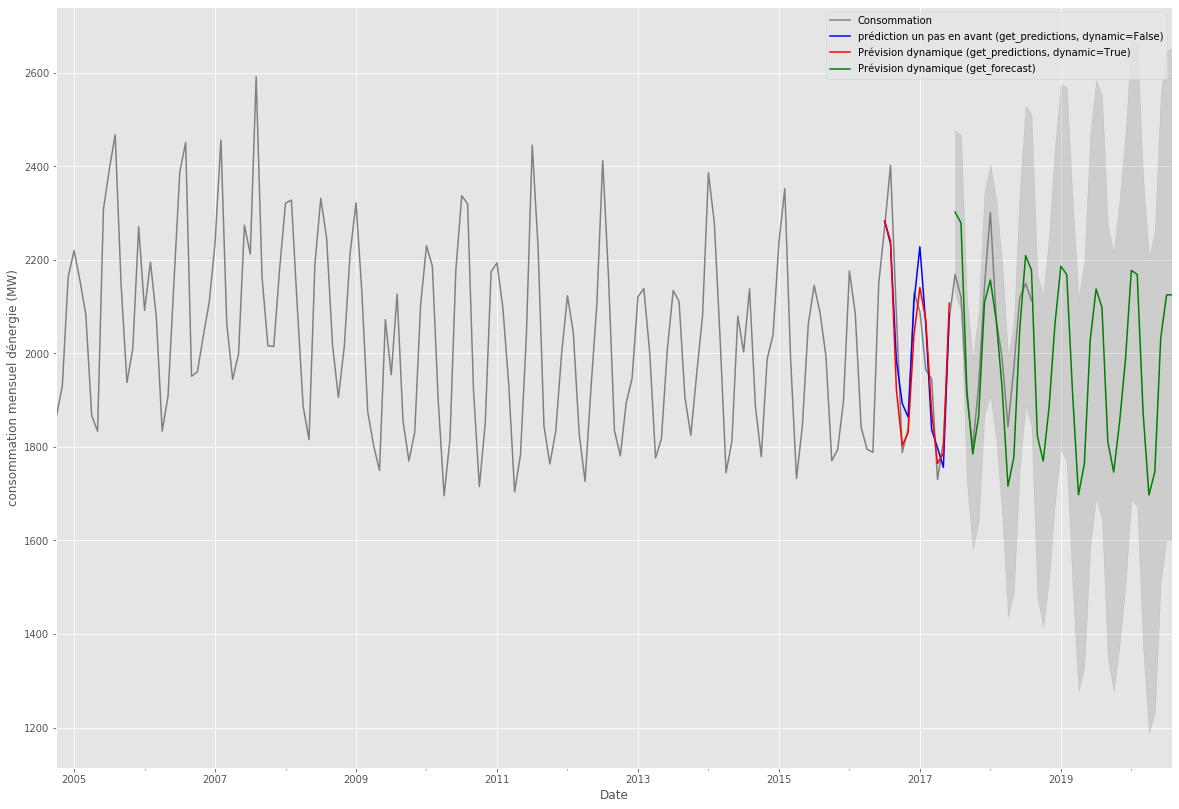

In [17]:
ax = new_data.plot(figsize=(20,14) , color = "grey")
pred0.predicted_mean.plot(ax=ax, label='prédiction un pas en avant (get_predictions, dynamic=False)', color="blue")
pred1.predicted_mean.plot(ax=ax, label='Prévision dynamique (get_predictions, dynamic=True)', color='red')
pred2.predicted_mean.plot(ax=ax, label='Prévision dynamique (get_forecast)', color="green")
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('consommation mensuel dénergie (MW)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [18]:
prediction = pred2.predicted_mean['2017-07-01':'2018-08-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = tf.keras.metrics.mean_absolute_percentage_error(truth,prediction)

print('Lerreur moyenne absolue en pourcentage pour les prévisions de lannée 2018 est {:.2f}%'.format(MAPE))

Lerreur moyenne absolue en pourcentage pour les prévisions de lannée 2018 est 3.96%


In [26]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(
    truth, prediction
)
print('MSE: %f' % mse)

MSE: 9911.495810


In [28]:
from sklearn.metrics import mean_absolute_error
MAP=mean_absolute_error(
    truth, prediction
)
print('MAP: %f' % MAP)

MAP: 81.642935


In [29]:

RMSE = math.sqrt(mse)
print("Root Mean Square Error:\n")
print(RMSE)


Root Mean Square Error:

9.035648038546283
